# Congressional Reapportionment and the 2020 Census

This notebook provides access to the data and analysis underpinning the bit.io analysis of Congressional Apportionment data. In particular, the analysis considers the question of whether the present method of congressional apportionment favors "small states" or "large states" (in terms of population).

Data for the analysis can be found in [this bit.io repository](https://l.bit.io/census-apportionment-dl) or accessed programmatically (see below).

## Imports and Setup
To run obtain the data, you'll need to log into your bit.io account and obtain your API key.

You can get your API key by logging into bit.io and scrolling down to the "Connect any data tool" box, clicking on "API/SDK", and copying the key from there.

See https://docs.bit.io/docs/connecting-to-bitio for screenshots and examples.

In [1]:
# Need help? Reach out to support@bit.io!
import bitdotio
import dotenv
from getpass import getpass
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import pandas as pd
import seaborn as sns

if os.getenv("BITDOTIO_API_KEY"):
    print("bit.io API Key Present in Global Environment")
else:
    os.environ["BITDOTIO_API_KEY"] = getpass("Please enter your API Key")

# Check out https://github.com/bitdotioinc/python-bitdotio for more examples and documentation
client = bitdotio.bitdotio(os.environ.get("BITDOTIO_API_KEY"))

## Getting the Data We Need

In [2]:
historical = '''
SELECT *
FROM "bitdotio/2020_Census_Reapportionment"."Historical Apportionment";
'''

census_2020 = '''
SELECT "bitdotio/2020_Census_Reapportionment"."2010 and 2020 Apportionment Populations"."State",
       "2020 Census Apportionment Population",
       "2020" as "apportionment_2020"
FROM "bitdotio/2020_Census_Reapportionment"."2010 and 2020 Apportionment Populations"
INNER JOIN "bitdotio/2020_Census_Reapportionment"."Apportionment Counts 1910 to 2020"
ON "bitdotio/2020_Census_Reapportionment"."2010 and 2020 Apportionment Populations"."State" =
   "bitdotio/2020_Census_Reapportionment"."Apportionment Counts 1910 to 2020"."State";
'''

def pandas_query_bitdotio(client, sql):
    '''Query bit.io and return a pandas dataframe'''
    try:
        # Connect to bit.io
        conn = client.get_connection()
        # Execute sql
        return pd.read_sql(sql, conn)
    except (Exception) as e:
        print(e)
    finally:
        if conn is not None:
            conn.close()
            
df_historical = pandas_query_bitdotio(client, historical)
df_2020 = pandas_query_bitdotio(client, census_2020)

# Computing Apportionment Counts for 2020

Our `df_2020` dataframe already includes the apportionment counts as calculated by the Census Bureau. But we can check their work. We will use the Huntington-Hill method of apportionment as detailed [here](https://math.libretexts.org/Bookshelves/Applied_Mathematics/Math_in_Society_(Lippman)/04%3A_Apportionment/4.05%3A_Huntington-Hill_Method).

First, let's take a look at the data we're working with:

In [3]:
df_2020.sort_values(by = "2020 Census Apportionment Population")

,State,2020 Census Apportionment Population,apportionment_2020
49,Wyoming,577719,1
44,Vermont,643503,1
1,Alaska,736081,1
33,North Dakota,779702,1
40,South Dakota,887770,1
7,Delaware,990837,1
25,Montana,1085407,2
38,Rhode Island,1098163,2
18,Maine,1363582,2
28,New Hampshire,1379089,2


We have all we need to compute the apportionment values for ourselves. There are no missing values, and we haven't included any rows for regions or totals. So let's get to it!

In [4]:
n_seats = 435

def hh(n_seats = 435, pops = df_2020["2020 Census Apportionment Population"]):
    total_population = sum(pops)
    divisor = total_population / n_seats
    quota = np.array(pops) / divisor
    allocated_seats = np.modf(quota)[1]
    geom_mean = np.sqrt(allocated_seats * (allocated_seats + 1))
    allocated_seats[quota > geom_mean] += 1

    while allocated_seats.sum() != n_seats:
        if allocated_seats.sum() > n_seats:
            divisor += 1
        else:
            divisor -= 1
        
        quota = np.array(pops) / divisor
        allocated_seats = np.modf(quota)[1]
        geom_mean = np.sqrt(allocated_seats * (allocated_seats + 1))
        allocated_seats[quota > geom_mean] += 1
        #allocated_seats[allocated_seats == 0] = 1

    return allocated_seats

df_2020["hh_apportionment_computed"] = hh()

In [5]:
np.all(df_2020["hh_apportionment_computed"] == df_2020["apportionment_2020"])

True

It looks like we got it right! More importantly, it looks like the Census Bureau got it right! We can also compute the old method, Webster's method, which was used until 1941. Details on Webster's method can be found [here](https://math.libretexts.org/Bookshelves/Applied_Mathematics/Math_in_Society_(Lippman)/04%3A_Apportionment/4.04%3A_Websters_Method).

In [6]:
n_seats = 435

def webster(n_seats = 435, pops = df_2020["2020 Census Apportionment Population"]):
    total_population = sum(pops)
    divisor = total_population / n_seats
    allocated_seats = np.round(np.array(pops) / divisor , 0)
    allocated_seats[allocated_seats == 0] = 1
    while allocated_seats.sum() != n_seats:
        if allocated_seats.sum() > n_seats:
            divisor += 1
        else:
            divisor -= 1
        
        allocated_seats = np.round(np.array(pops) / divisor , 0)
        allocated_seats[allocated_seats == 0] = 1

    return allocated_seats

df_2020["webster_apportionment_computed"] = webster()
df_2020.loc[df_2020["hh_apportionment_computed"] != df_2020["webster_apportionment_computed"],
            ["State", "2020 Census Apportionment Population", "hh_apportionment_computed", "webster_apportionment_computed"]]

,State,2020 Census Apportionment Population,hh_apportionment_computed,webster_apportionment_computed
25,Montana,1085407,2.0,1.0
31,New York,20215751,26.0,27.0
34,Ohio,11808848,15.0,16.0
38,Rhode Island,1098163,2.0,1.0


The Huntington-Hill method replaced Webster's method because of an alleged bias toward large states. Can we detect that by looking at the differences in how the two methods would apportion seats in 2020?

First of all, the two methods agree on the apportionment of 433 out of 435 House seats: that's more than 99% agreement. Webster's method would apportion two seats to different states than the Huntington-Hill method: New York and Ohio would both receive an additional seat at the cost of a seat each from Rhode Island and Montana. So where the two methods differ, Webster's method does, indeed, favor more populous states (Ohio and New York) while Huntington-Hill favors less-populous states (Rhode Island and Montana).

We can explore differences between large and small states in terms of the number of individuals represented by each representative in each state. If a representative has a relatively small number of constituents, each of those constituents has more political power. Conversely, if a representative has a large number of constituents, the political power of each constituent is "diluted."

<ipython-input-8-af3307ac006e>:44: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = plt.legend(


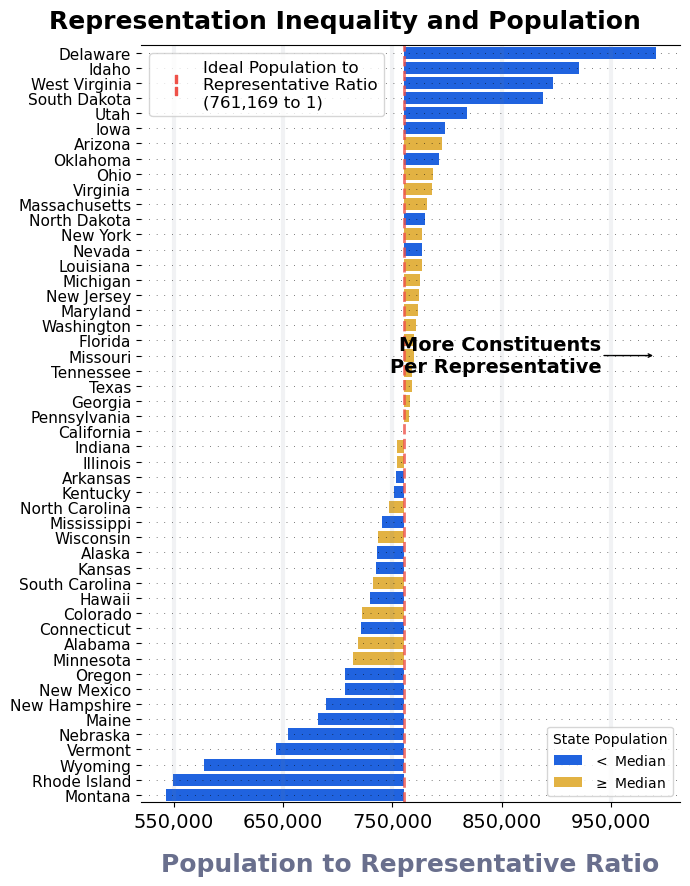

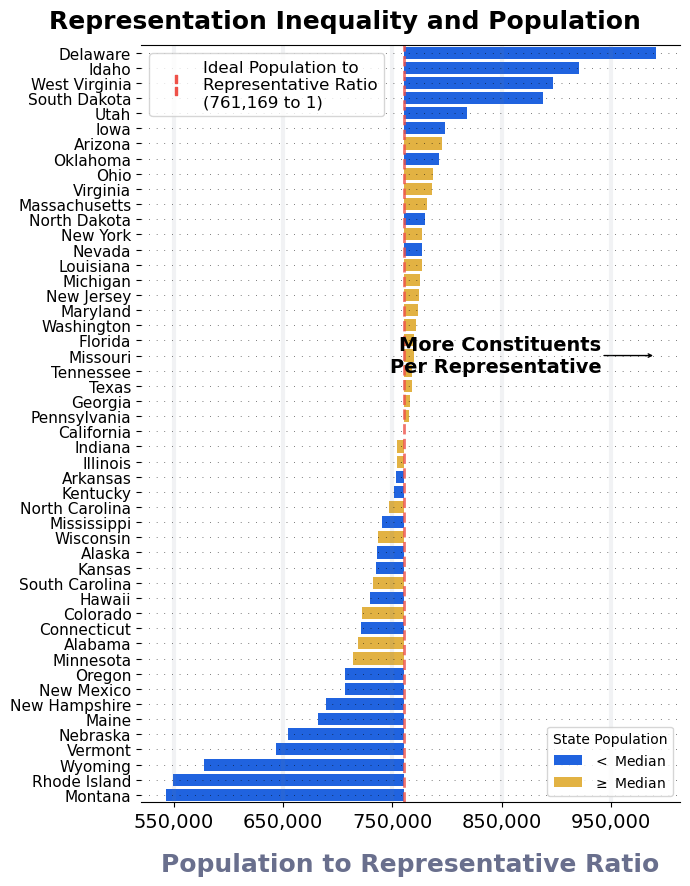

In [8]:
COLORS = sns.color_palette("Set2").as_hex()
COLORS[0] = '#0059ff'
COLORS[1] = '#fdbd28'
COLORS[2] = '#EE5149'
RED = '#EE5149'
DGREY = '#060F41'
GREY = '#788995'


# Prepare the Data
fig_df = df_2020.loc[
    :, ["State", "2020 Census Apportionment Population", "apportionment_2020"]
].rename(columns={"apportionment_2020": "Seats"})

ideal = fig_df["2020 Census Apportionment Population"].sum() / 435
fig_df["rep_ratio"] = fig_df["2020 Census Apportionment Population"] / fig_df["Seats"]
fig_df["diff_from_ideal"] = fig_df["rep_ratio"] - ideal
median_size = fig_df["2020 Census Apportionment Population"].median()
fig_df["Size"] = None
fig_df.loc[
    fig_df["2020 Census Apportionment Population"] >= median_size, "Size"
] = r"$\geq$ Median"  # "Higher Population"
fig_df.loc[
    fig_df["2020 Census Apportionment Population"] < median_size, "Size"
] = r"$<$ Median"
plt_sub = fig_df.loc[:, ("State", "diff_from_ideal", "Size")].sort_values(
    "diff_from_ideal", ascending=False
)

# Plot
fig, ax = plt.subplots(figsize=(7, 9), dpi=100)
sns.barplot(
    ax=ax,
    x="diff_from_ideal",
    y="State",
    data=plt_sub,
    hue="Size",
    dodge=False,
    palette=[COLORS[0], COLORS[1]],
)
vline = plt.axvline(x=0, c=RED, alpha=0.8, linewidth=2, linestyle="--")


new_legend = plt.legend(
    [vline],
    ["Ideal Population to\nRepresentative Ratio\n(761,169 to 1)"],
    loc="upper left",
    fontsize=12,
    handles=[
        matplotlib.lines.Line2D(
            [],
            [],
            color=RED,
            marker="$\u254e$",
            linestyle="None",
            markersize=15,
            markeredgewidth=1,
            label="Ideal Population to\nRepresentative Ratio\n(761,169 to 1)",
        )
    ],
)
ax.set_xlabel(
    "Population to Representative Ratio",
    size=18,
    color=DGREY,
    alpha=0.6,
    fontweight="bold",
    labelpad=15,
)
ax.yaxis.label.set_visible(False)
ax.tick_params(axis="y", which="major", labelsize=11)
ax.tick_params(axis="x", which="major", labelsize=14)
ax.grid(b=True, color=GREY, alpha=0.1, linewidth=3)
ax.grid(
    b=True, axis="y", color="#000000", alpha=1, linewidth=0.5, linestyle=(0, (1, 10))
)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)
ax.legend(title="State Population", loc="lower right")
fig.suptitle(
    "Representation Inequality and Population",
    x=0.5,
    y=0.98,
    fontweight="bold",
    fontsize=18,
)

ideal = 761169
start = -211169
ax.set_xticks([start + x for x in range(0, 500000, 100000)])
ax.set_xticklabels(["550,000", "650,000", "750,000", "850,000", "950,000"])
plt.gca().add_artist(new_legend)

ax.text(
    180000,
    20,
    "More Constituents\nPer Representative",
    va="center",
    ha="right",
    fontweight="bold",
    fontsize=14,
)
# ax.arrow(160000, 20, 50000, 0, color='k', width=0.08, head_length=10000)
ar = matplotlib.patches.FancyArrowPatch(
    (180000, 20), (230000, 20), arrowstyle="->", color="k", mutation_scale=6
)
plt.gca().add_patch(ar)

for spine in ["right", "left"]:
    ax.spines[spine].set_visible(False)

# ax.set_xticklabels([ideal-200000, ideal-100000, ideal, ideal+100000, ideal+200000])
fig.tight_layout()
plt.show()

What do we see here? From the looks of it, small states -- states with populations below the median state population -- are more likely to have particularly high or particularly low population-to-representative ratios compared to the "ideal" of about 760,000 people per representative (this "ideal" comes from dividing the total U.S. population by the total number of representatives and would represent the case where each representative has the same number of constituents). Small states vary a lot more in terms of the amount of (mis)representation they have in the U.S. House of Representatives.

# What's next?

Huntington-Hill's Method and Webster's Method aren't the only apportionment methods! Try to implement some of the other methods described [here](https://math.libretexts.org/Bookshelves/Applied_Mathematics/Math_in_Society_(Lippman)/04%3A_Apportionment). Though the implementations are similar, they differ in subtle but important ways.

# Other Interesting Resources
- The [bit.io repository](https://l.bit.io/census-apportionment-dl) with 2020 Census and Apportionment data
- U.S. Census Bureau site with [Apportionment Data and Visualizations](https://www.census.gov/data/tables/2020/dec/2020-apportionment-data.html)
- [Mathematics Libretext: Math in Society Chapter on Apportionment](https://math.libretexts.org/Bookshelves/Applied_Mathematics/Math_in_Society_(Lippman)/04%3A_Apportionment)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0647337b-7f07-49a6-b0f4-6b6bfc2e14c4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>